Aiko Evelyn
220711768
H2O
Klasifikasi Jenis Jamur
MobileNet

In [28]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [29]:
count = 0
dirs = os.listdir(r'D:\Kuliah\SEMESTER 5\ML\UAS\Dataset Project UAS_A_H2O\train_data')
for dir in dirs:
    files = list(os.listdir(r'D:\Kuliah\SEMESTER 5\ML\UAS\Dataset Project UAS_A_H2O\train_data/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

JamurKuping Folder has 100 Images
JamurReishi Folder has 100 Images
JamurShitake Folder has 100 Images
Images Folder has 300 Images


In [30]:
base_dir = r'D:\Kuliah\SEMESTER 5\ML\UAS\Dataset Project UAS_A_H2O\train_data'
img_size = 180
batch= 32
validation_split = 0.1

In [31]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
)

Found 300 files belonging to 3 classes.


In [32]:
class_names = dataset.class_names
print("Class Names:", class_names)

Class Names: ['JamurKuping', 'JamurReishi', 'JamurShitake']


Train-Validation-Test Split

In [33]:
train_split = 0.8
validation_split = 0.1
test_split = 0.1

total_count = len(dataset)

train_count = int(total_count * train_split)
val_count = int(total_count * validation_split)
test_count = total_count - train_count - val_count  

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)
print("Test Images:", test_count)

train_ds = dataset.take(train_count)  
remaining_ds = dataset.skip(train_count)  

val_ds = remaining_ds.take(val_count)  
test_ds = remaining_ds.skip(val_count)

Total Images: 10
Train Images: 8
Validation Images: 1
Test Images: 1


In [34]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

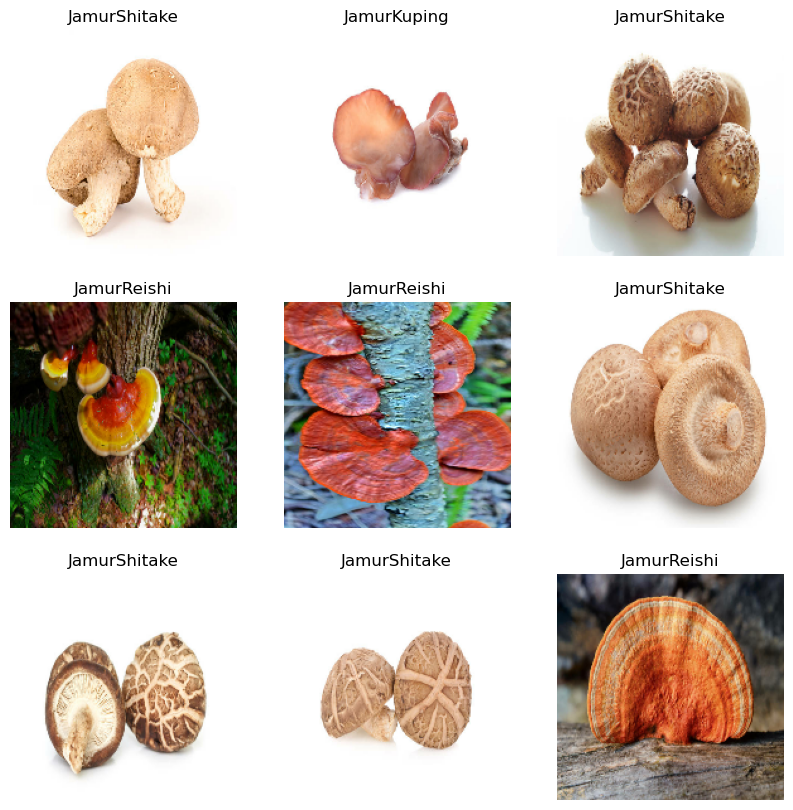

In [35]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1) 
        plt.imshow(images[i].numpy().astype('uint8')) 
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [36]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)

(32, 180, 180, 3)


In [37]:
AUTOTUNE = tf.data.AUTOTUNE

In [38]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [39]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

Data Augmentation

In [40]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

C:\Users\pf34h\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


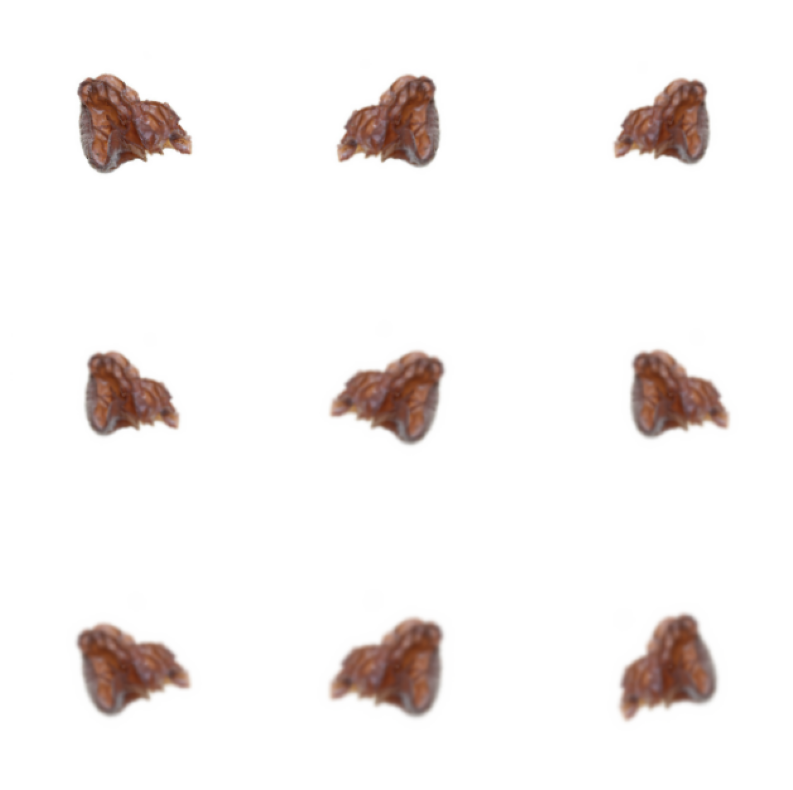

In [41]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [42]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model

base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))

base_model.trainable = True
fine_tune_at = len(base_model.layers)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = Sequential ([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

C:\Users\pf34h\AppData\Local\Temp\ipykernel_2156\191715207.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape=(img_size, img_size, 3))


In [43]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 5, 5, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,360,451 (12.82 MB)

 Trainable params: 131,587 (514.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               mode='max')

history= model.fit(train_ds, 
                   epochs=30, 
                   validation_data=val_ds,  
                   callbacks=[early_stopping])

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 653ms/step - accuracy: 0.4848 - loss: 1.3022 - val_accuracy: 0.7500 - val_loss: 0.7293
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - accuracy: 0.5910 - loss: 0.9617 - val_accuracy: 0.9091 - val_loss: 0.3714
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.7706 - loss: 0.5827 - val_accuracy: 0.9318 - val_loss: 0.2223
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - accuracy: 0.9280 - loss: 0.2893 - val_accuracy: 0.9773 - val_loss: 0.1581
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.8928 - loss: 0.2883 - val_accuracy: 1.0000 - val_loss: 0.1234
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - accuracy: 0.9550 - loss: 0.1853 - val_accuracy: 0.9773 - val_loss: 0.0966
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.9547 - loss: 0.1562 - val_accuracy: 0.9773 - val_loss: 0.0783
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step - accuracy: 0.9849 - loss: 0.0901 - val_accuracy: 0.9773 - val_loss

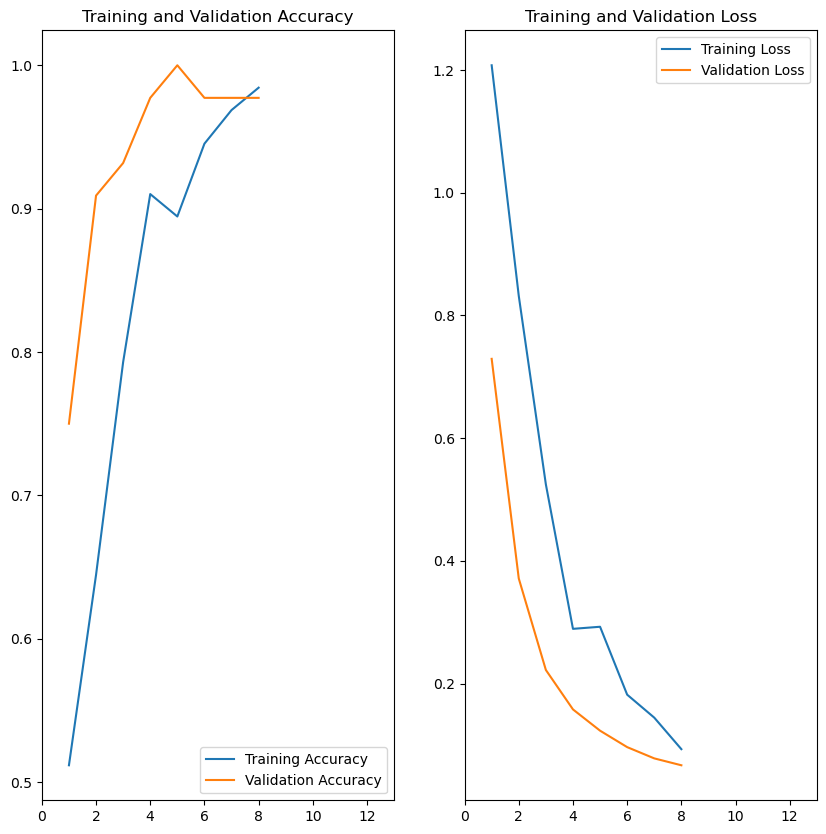

In [46]:
ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy') 
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(0, 13)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [47]:
model.save('BestModel_MobileNet_H2O.h5')

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

model = load_model(r'D:\Kuliah\SEMESTER 5\ML\UAS\BestModel_MobileNet_H2O.h5') 
class_names = ['JamurKuping', 'JamurReishi', 'JamurShitake']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180)) 
        input_image_array = tf.keras.utils.img_to_array(input_image) 
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  

        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result) 
        confidence = np.max(result) * 100 

  
        print(f"Prediksi: {class_names[class_idx]}") 
        print(f"Confidence: {confidence:.2f}%")

       
        input_image = Image.open(image_path)
        input_image.save(save_path) 

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"
    
result = classify_images(r'D:\Kuliah\SEMESTER 5\ML\UAS\Dataset Project UAS_A_H2O\test_data\reishi\reishi (9).jpg', save_path='reishi.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
Prediksi: JamurReishi
Confidence: 56.96%
Prediksi: JamurReishi dengan confidence 56.96%. Gambar asli disimpan di reishi.jpg.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


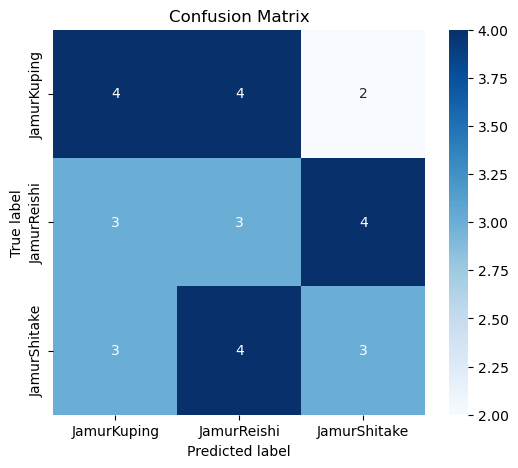

Confusion Matrix:
 [[4 4 2]
 [3 3 4]
 [3 4 3]]
Akurasi: 0.3333333333333333
Presisi: [0.4        0.27272727 0.33333333]
Recall: [0.4 0.3 0.3]
F1 Score: [0.4        0.28571429 0.31578947]


In [49]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

# Muat model
mobileNet_model = load_model(r'D:\Kuliah\SEMESTER 5\ML\UAS\BestModel_MobileNet_H2O.h5')

# Kompilasi ulang model
mobileNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load dataset untuk pengujian
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Kuliah\SEMESTER 5\ML\UAS\Dataset Project UAS_A_H2O\test_data', 
    labels='inferred', 
    label_mode='categorical', 
    batch_size=32, 
    image_size=(180, 180)
)

# Prediksi menggunakan model
y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)

# Mendapatkan true labels dari test_data
true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
true_labels = tf.convert_to_tensor(true_labels)

# Membuat confusion matrix
conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

# Menghitung metrik evaluasi
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["JamurKuping", "JamurReishi", "JamurShitake"], 
            yticklabels=["JamurKuping", "JamurReishi", "JamurShitake"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Print hasil metrik evaluasi
print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
